Verify the imports
NOTE: Please do NOT edit this panel! 

In [2]:
# System packages 
import os
import pathlib 
import sys 
import warnings
warnings.filterwarnings('ignore') # Ignore all the warnings 

# Path hidpy
sys.path.append('%s/../' % os.getcwd())

# Internal packages 
import core 
from core import file_utils
from core import optical_flow
from core import video_processing
from core import plotting
from core import msd
from core import inference

## Input Panel 

In [3]:
############ INPUTS PANEL, YOU CAN EDIT THIS PANEL ############ 
# Input video sequence (single sequence)   
video_sequence = '%s/../data/protocol/rna/rna.avi' % os.getcwd()

# Pixel threshold, this value should be tested with trial-and-error
pixel_threshold = 150

# Pixel size (should be in microns, and should be known from the microscope camera)
pixel_size = 0.088 # This is for the confocal samples  
# pixel_size = 0.042 # This is for the SIM samples 

# Time step (should be in seconds)
dt = 0.200 # This is for the confocal samples 
# dt = 2.0 # This is for the SIM samples 

# The models. Users must either select all or some of them  
models_selected = ['D','DA','V','DV','DAV'] 

# Output directory 
root_output_directory = '%s/../output-protocol/' % os.getcwd()

# Get the prefix, typically with the name of the video sequence  
prefix = '%s_pixel-%2.2f_dt-%2.2f_threshold_%s' % (pathlib.Path(video_sequence).stem, pixel_size, dt, pixel_threshold)

## Load Video Sequence

In [4]:
################# PLEASE DON'T EDIT THIS PANEL #################
# Verify the input parameters, and return the path where the output data will be written  
output_directory = file_utils.veryify_input_options(
    video_sequence=video_sequence, output_directory=root_output_directory, 
    pixel_threshold=pixel_threshold, pixel_size=pixel_size, dt=dt)

# Load the frames from the video 
frames = video_processing.get_frames_list_from_video(
    video_path=video_sequence, verbose=True)

NOTE: The output path [/ssd1/projects/hidpy/notebooks/../output-protocol/] exists
	* Video Details: 
  	* Name: /ssd1/projects/hidpy/notebooks/../data/protocol/rna/rna.avi 
  	* Number Frames 150  	* FPS: 7.000000


100%|██████████████████████████████████████████████████| 150/150 [00:00<00:00, 311.46it/s]


## Plot Video Frames

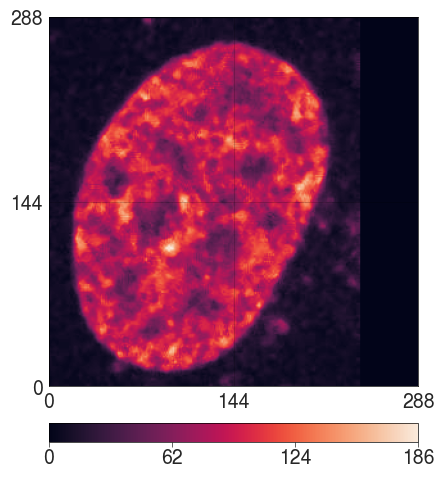

In [5]:
################# PLEASE DON'T EDIT THIS PANEL #################
# Plot the first frames
plotting.verify_plotting_packages()
plotting.plot_frame(frame=frames[0], output_directory=output_directory, 
    frame_prefix=prefix, font_size=14, tick_count=3)

## Compute Optical Flow

In [6]:
################# PLEASE DON'T EDIT THIS PANEL #################
# Compute the optical flow
print('* Computing optical flow') 
u, v = optical_flow.compute_optical_flow_farneback(frames=frames)

* Computing optical flow


100%|██████████████████████████████████████████████████| 149/149 [00:01<00:00, 74.58it/s]

Optical flow Time 2.000058


# Interpolate Optical Flow Fields

In [7]:
################# PLEASE DON'T EDIT THIS PANEL #################
# Interpolate the flow field
print('* Computing interpolations')
u, v = optical_flow.interpolate_flow_fields(u_arrays=u, v_arrays=v)

* Computing interpolations


100%|██████████████████████████████████████████████████| 149/149 [00:01<00:00, 133.02it/s]

Interpolation Time 1.122042


## Create Trajectories

In [10]:
################# PLEASE DON'T EDIT THIS PANEL #################
# Compute the trajectories 
print('* Creating trajectories')
trajectories = optical_flow.compute_trajectories(
    frame=frames[0], fu_arrays=u, fv_arrays=v, pixel_threshold=pixel_threshold)
    
# Plot the trajectories 
print('* Plotting trajectories')
trajectory_image_prefix = '%s_trajectory' % prefix
plotting.plot_trajectories_on_frame(
    frame=frames[0], trajectories=trajectories, 
    output_path='%s/%s' % (output_directory, trajectory_image_prefix))

* Creating trajectories


100%|██████████████████████████████████████████████████| 288/288 [00:00<00:00, 498.37it/s]

Trajectory Computation Time 0.580380
* Plotting trajectories


## Compute the Mean Square Displacement (MSD) Map

In [11]:
# Calculation of the MSD (mean square displacement)

# Construct trajectory map
print('* Converting the trajectories to maps')
xp, yp = msd.convert_trajectories_to_map(trajectories, (len(frames), frames[0].shape[0], frames[0].shape[1]))

# Convert displacement values to microns
xp_um = xp * pixel_size
yp_um = yp * pixel_size

# Extract nucleoli mask
print('* Extracting the nucleoli mask')
mask_nucleoli = msd.extract_nucleoli_map(xp_um, yp_um)

# Compute the MSDs
print('* Computing the MSDs')
msd_array = msd.calculate_msd_for_every_pixel(xp_um, yp_um, mask_nucleoli)

# Compute the inference, Baysian fit on MSDs 
print('* Fitting the MSDs models using Bayesian inference')
warnings.filterwarnings('ignore') # Ignore all the warnings 
bayes = inference.apply_bayesian_inference(msd_array, dt, models_selected)

* Converting the trajectories to maps
* Extracting the nucleoli mask
* Computing the MSDs
* Fitting the MSDs models using Bayesian inference
Bayesian inference..
Using # cores:20


100%|██████████| 153/153 [00:00<00:00, 908.04it/s]


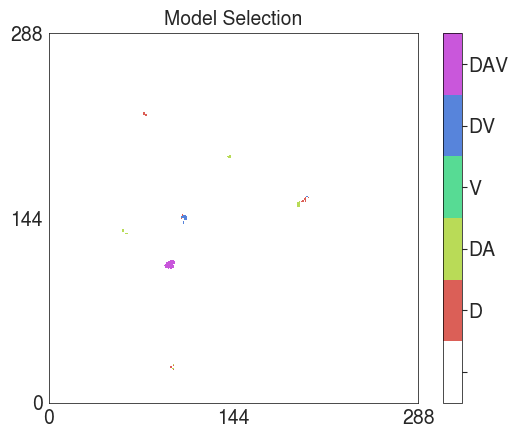

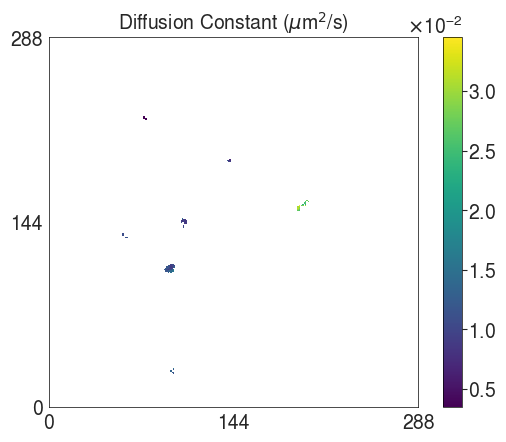

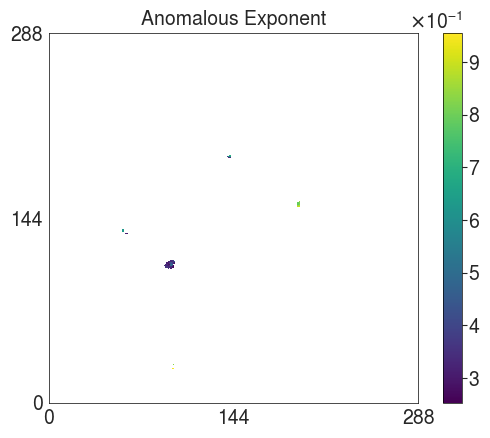

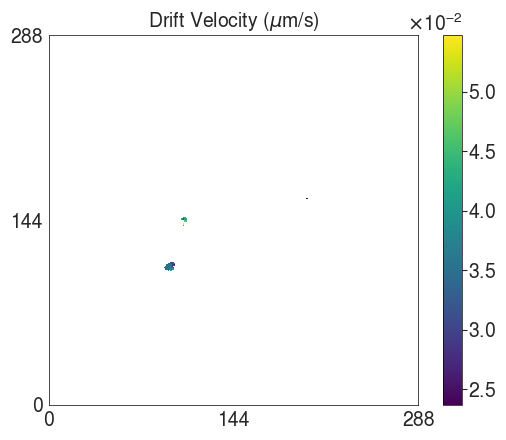

In [12]:
import numpy as np
import core 

# The matrix that contains the mask of the nucli
# TODO: What is the hard-coded value of 100?
mask_matrix = np.zeros((frames[0].shape[0], frames[0].shape[1]))
mask_matrix[np.where(mask_nucleoli == 1) ] = 100

# Get the diffusion constant map (D)
diffusion_constant_matrix = bayes['D']
diffusion_constant_matrix[np.where(bayes['model'] == 0)] = np.nan
diffusion_constant_matrix[np.where(bayes['D'] < 1e-10)] = np.nan

# Get the anomalous exponent matrix (A)
anomalous_exponent_matrx = bayes['A']
anomalous_exponent_matrx[np.where(bayes['model'] == 0)] = np.nan
anomalous_exponent_matrx[np.where(bayes['A'] < 1e-10)] = np.nan

# Get the drift velocity matrix (V)
drift_velocity_matrix = bayes['V']
drift_velocity_matrix[np.where(bayes['model'] == 0)] = np.nan
drift_velocity_matrix[np.where(bayes['V']==0)] = np.nan

# Plot the model selection image 
model_selection_image_prefix = '%s_model_selection' % prefix
core.plotting.plot_model_selection_image(
    model_selection_matrix=bayes['model'], mask_matrix=mask_matrix, 
    output_directory=output_directory, frame_prefix=model_selection_image_prefix, 
    font_size=14, title='Model Selection', tick_count=3)

# Plot the diffusion constant matrix
d_map_image_prefix = '%s_diffusion_constant_matrix' % prefix
core.plotting.plot_matrix_map(
    matrix=diffusion_constant_matrix, mask_matrix=mask_matrix, 
    output_directory=output_directory, frame_prefix=d_map_image_prefix, 
    font_size=14, title=r'Diffusion Constant ($\mu$m$^2$/s)', tick_count=3)

# Plot the anomalous matrix
a_map_image_prefix = '%s_anomalous_matrix' % prefix
core.plotting.plot_matrix_map(
    matrix=anomalous_exponent_matrx, mask_matrix=mask_matrix, 
    output_directory=output_directory, frame_prefix=a_map_image_prefix, 
    font_size=14, title='Anomalous Exponent', tick_count=3)

# Plot the drift velocity matrix
v_map_image_prefix = '%s_drift_velocity_matrix' % prefix
core.plotting.plot_matrix_map(
    matrix=drift_velocity_matrix, mask_matrix=mask_matrix, 
    output_directory=output_directory, frame_prefix=v_map_image_prefix, 
    font_size=14, title=r'Drift Velocity ($\mu$m/s)', tick_count=3)

In [13]:
# Save pickle file per cell
import pickle

# Create the pickle directory 
pickle_directory = '%s/pickle' % output_directory
file_utils.create_directory(pickle_directory)

# Save the pickle file 
with open('%s/%s.pickle' % (pickle_directory, prefix), 'wb') as f:
    pickle.dump(bayes, f)

## Create the HTML Report 

In [15]:
# Generate report 
file_utils.create_report_1_summary(output_directory=output_directory,
                                   frame_0=prefix,
                                   trajectory=trajectory_image_prefix,
                                   model_selection=model_selection_image_prefix, 
                                   d_map=d_map_image_prefix, 
                                   a_map=a_map_image_prefix,
                                   v_map=v_map_image_prefix)